# Parameter Inference

Here we infer the parameters of the systems we have observed.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pystan
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import scipy.stats as ss
import seaborn as sns
import sys
from tqdm import tqdm_notebook
from true_params import uncert

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Now we compile the model and fit one of the systems just to check:

In [3]:
with h5py.File('observations.h5', 'r') as f:
    m1s = array(f['m1s'])
    m2s = array(f['m2s'])
    zs = array(f['zs'])
    dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
    thetas = array(f['thetas'])
    
    mcobs = array(f['mcobs'])
    etaobs = array(f['etaobs'])
    rhoobs = array(f['rhoobs'])
    thetaobs = array(f['thetaobs'])
    
    sigma_mc = array(f['sigma_mc'])
    sigma_eta = array(f['sigma_eta'])
    sigma_rho = array(f['sigma_rho'])
    sigma_theta = array(f['sigma_t'])
    
with h5py.File('optimal_snr.h5', 'r') as f:
    ms_osnr = array(f['ms'])
    osnrs = array(f['SNR'])

In [4]:
model = pystan.StanModel('infer.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_840f42e0771feff0d20de4dd8c772037 NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpup5bi58c/stanfit4anon_model_840f42e0771feff0d20de4dd8c772037_3123636895261828366.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


We try to fit the system with the largest $d_L$, just because it will be very challenging for us to get right (it's a 3-sigma upward fluctuation in the SNR, for example!).

In [5]:
ifit = argmax(dls)

data = {
    'mc_obs': mcobs[ifit],
    'eta_obs': etaobs[ifit],
    'rho_obs': rhoobs[ifit],
    'theta_obs': thetaobs[ifit],
    
    'sigma_mc': sigma_mc[ifit],
    'sigma_eta': sigma_eta[ifit],
    'sigma_theta': sigma_theta[ifit],
    
    'nm': len(ms_osnr),
    'ms': ms_osnr,
    'opt_snrs': osnrs,
    
    'dL_max': Planck15.luminosity_distance(3).to(u.Gpc).value,
}

In [6]:
fit = model.sampling(data=data, control={'adapt_delta': 0.99, 'metric': 'dense_e'})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22334da0>,
      dtype=object)

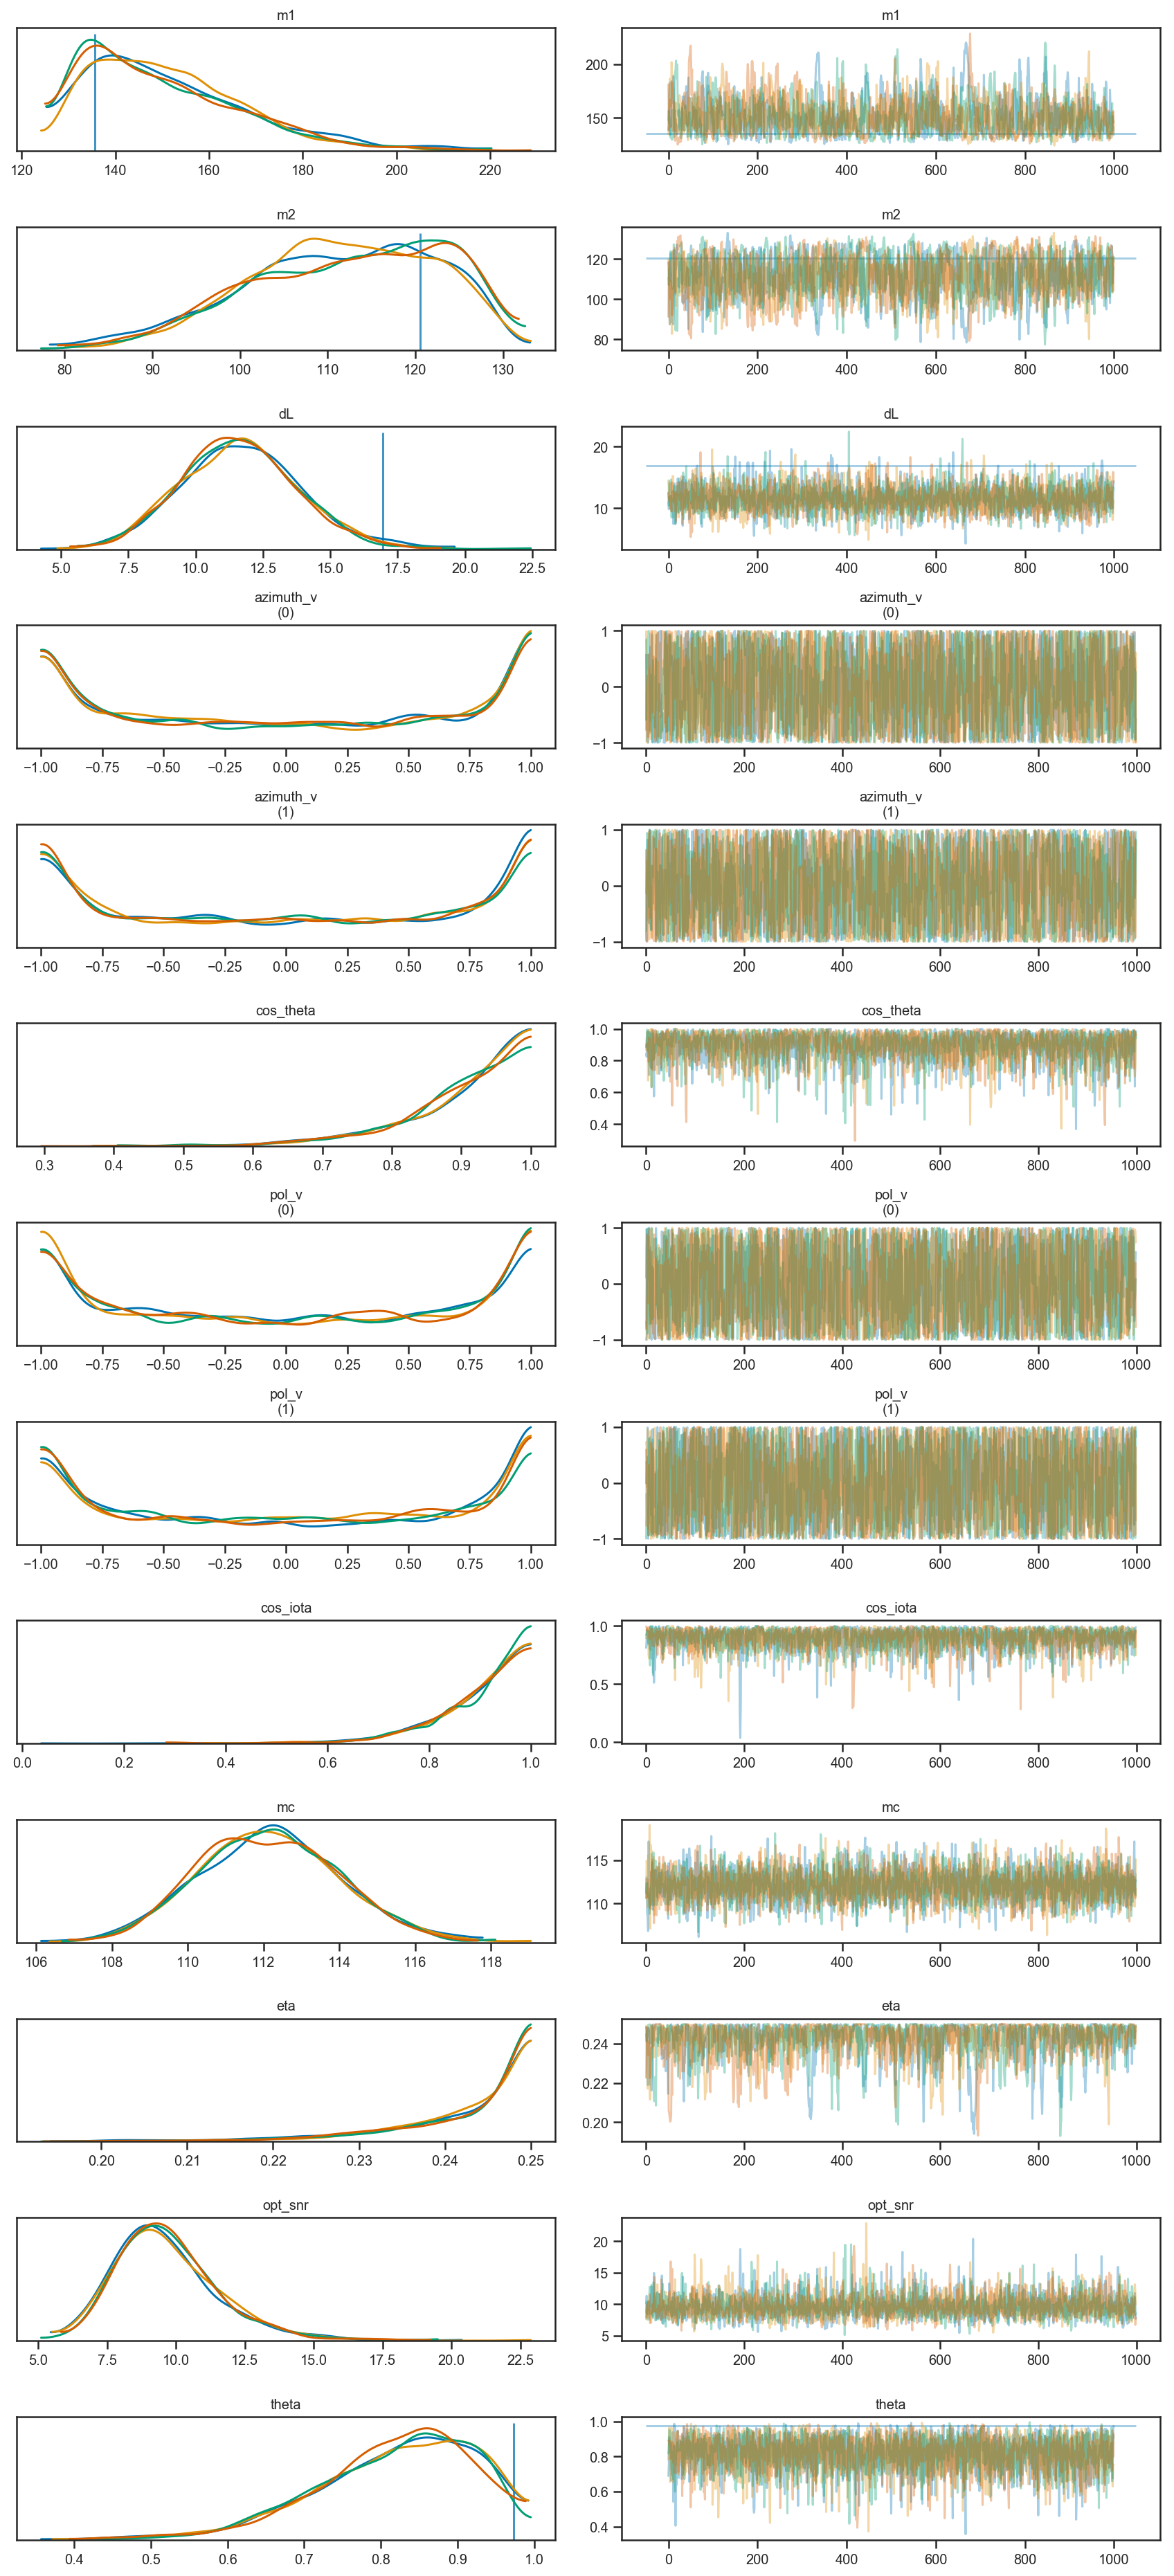

In [7]:
az.plot_trace(fit, lines=(('m1', {}, m1s[ifit]*(1+zs[ifit])),
                          ('m2', {}, m2s[ifit]*(1+zs[ifit])),
                          ('dL', {}, dls[ifit]),
                          ('theta', {}, thetas[ifit])))

The below fit takes a *long* time; it is superseded by ``infer.py``, which we can run on the cluster (12 cores FTW!).

In [ ]:
with h5py.File('observations.h5', 'a') as f:
    # Delete the group for posteriors:
    try:
        del f['posteriors']
    except:
        pass 
    
    pg = f.create_group('posteriors')
    
    nobs = len(mcobs)
    nsamp = 4000
    pg.create_dataset('dl', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)
    pg.create_dataset('m1det', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)
    pg.create_dataset('m2det', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)
    pg.create_dataset('theta', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)

    for i in tqdm_notebook(range(len(mcobs))):
        data = {
            'mc_obs': mcobs[i],
            'eta_obs': etaobs[i],
            'rho_obs': rhoobs[i],
            'theta_obs': thetaobs[i],

            'sigma_mc': sigma_mc[i],
            'sigma_eta': sigma_eta[i],
            'sigma_theta': sigma_theta[i],

            'nm': len(ms_osnr),
            'ms': ms_osnr,
            'opt_snrs': osnrs,

            'dL_max': 25.0
        }
        
        init = {
            'm1': m1s[i]*(1+zs[i]),
            'm2': m2s[i]*(1+zs[i]),
            'dL': dls[i]
        }
        
        fit = model.sampling(data=data, control={'max_treedepth': 15, 'adapt_delta': 0.99, 'metric': 'dense_e'}, init=4*(init,))
        chain = fit.extract(permuted=True)
        
        pg['dl'][i,:] = chain['dL']
        pg['m1det'][i,:] = chain['m1']
        pg['m2det'][i,:] = chain['m2']
        pg['theta'][i,:] = chain['theta']

## Checking results

In [9]:
with h5py.File('observations.h5', 'r') as f:
    m1s = array(f['m1s'])
    m2s = array(f['m2s'])
    zs = array(f['zs'])
    dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
    
    m1det_samples = array(f['posteriors']['m1det'])
    m2det_samples = array(f['posteriors']['m2det'])
    dl_samples = array(f['posteriors']['dl'])
    theta_samples = array(f['posteriors']['theta'])

First, let's look at some z-scores for $m_1$, $m_2$, and $d_L$:

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, '$p\\left( z_{d_L} \\right)$')

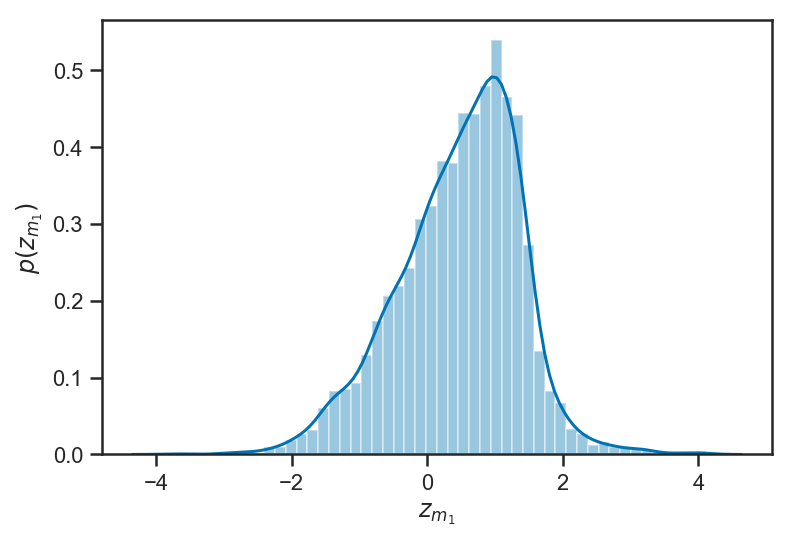

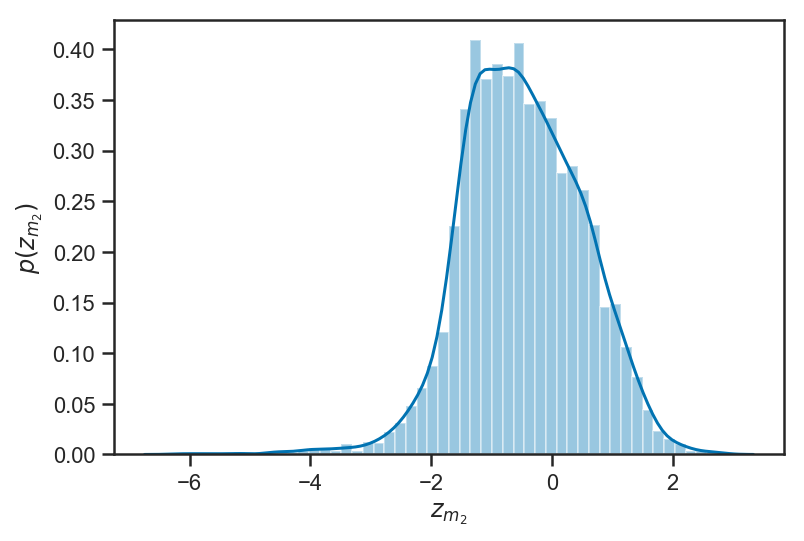

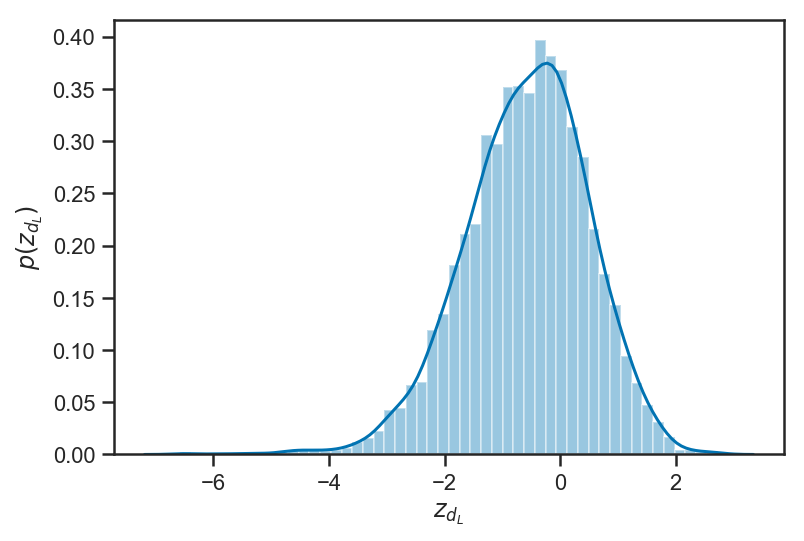

In [10]:
zscore_m1 = mean(m1det_samples - m1s[:,newaxis]*(1+zs[:,newaxis]), axis=1)/std(m1det_samples, axis=1)
sns.distplot(zscore_m1)
xlabel(r'$z_{m_1}$')
ylabel(r'$p\left( z_{m_1} \right)$')

figure()
zscore_m2 = mean(m2det_samples - m2s[:,newaxis]*(1+zs[:,newaxis]), axis=1)/std(m2det_samples, axis=1)
sns.distplot(zscore_m2)
xlabel(r'$z_{m_2}$')
ylabel(r'$p\left( z_{m_2} \right)$')

figure()
zscore_dl = mean(dl_samples - dls[:,newaxis], axis=1)/std(dl_samples, axis=1)
sns.distplot(zscore_dl)
xlabel(r'$z_{d_L}$')
ylabel(r'$p\left( z_{d_L} \right)$')

We are just looking for major outliers (since we have drawn 4M objects or so, out to $z = 3$, we expect even some 4-5 sigma outliers).  No surprises, I guess.

Another test we can do is to check the median uncertainties in masses and distances, and compare against GW170814.  The agreement is striking (well, we tuned it to be this way).

In [11]:
print('median 90% CI in log(m1) is {:.2f}'.format(median(quantile(log(m1det_samples), 0.95, axis=1) - quantile(log(m1det_samples), 0.05, axis=1))))
print('median 90% CI in log(m2) is {:.2f}'.format(median(quantile(log(m2det_samples), 0.95, axis=1) - quantile(log(m2det_samples), 0.05, axis=1))))
print('median 90% CI in log(dL) is {:.2f}'.format(median(quantile(log(dl_samples), 0.95, axis=1) - quantile(log(dl_samples), 0.05, axis=1))))

print()

print('GW170814 had {:.2f}, {:.2f}, {:.2f}'.format(log(30.5+5.7)-log(30.5-3.0), log(25.3+2.8)-log(25.3-4.2), log(540+130)-log(540-210)))

median 90% CI in log(m1) is 0.34
median 90% CI in log(m2) is 0.32
median 90% CI in log(dL) is 0.74

GW170814 had 0.27, 0.29, 0.71


In order to generate reliable selection effects, we need a dLmax that encloses the entire sample.

In [13]:
print('maximum estimated dL is {:.1f} Gpc'.format(np.max(dl_samples))), Planck15.luminosity_distance(3).to(u.Gpc)

maximum estimated dL is 24.0 Gpc


(None, <Quantity 26.03918355 Gpc>)

## Follow-up Outliers

In [18]:
model = pystan.StanModel('infer.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5e7d8094ffcf6f971fcddb7aca16f08 NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpz4lr8na7/stanfit4anon_model_f5e7d8094ffcf6f971fcddb7aca16f08_4646535757027403365.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


We try to fit the system with the largest $d_L$, just because it will be very challenging for us to get right (it's a 3-sigma upward fluctuation in the SNR, for example!).

In [110]:
ifit = argmin(neff)

print('fitting event with d_L zscore = {:.2f}'.format(zscore_dl[ifit]))

data = {
    'mc_obs': mcobs[ifit],
    'eta_obs': etaobs[ifit],
    'rho_obs': rhoobs[ifit],
    'theta_obs': thetaobs[ifit],
    
    'sigma_mc': sigma_mc[ifit],
    'sigma_eta': sigma_eta[ifit],
    'sigma_theta': sigma_theta[ifit],
    
    'nm': len(ms_osnr),
    'ms': ms_osnr,
    'opt_snrs': osnrs,
    
    'dL_max': Planck15.luminosity_distance(3).to(u.Gpc).value,
}

fitting event with d_L zscore = -1.74


In [111]:
fit = model.sampling(data=data, control={'adapt_delta': 0.99, 'metric': 'dense_e', 'max_treedepth': 15})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c6b47ffd0>,
      dtype=object)

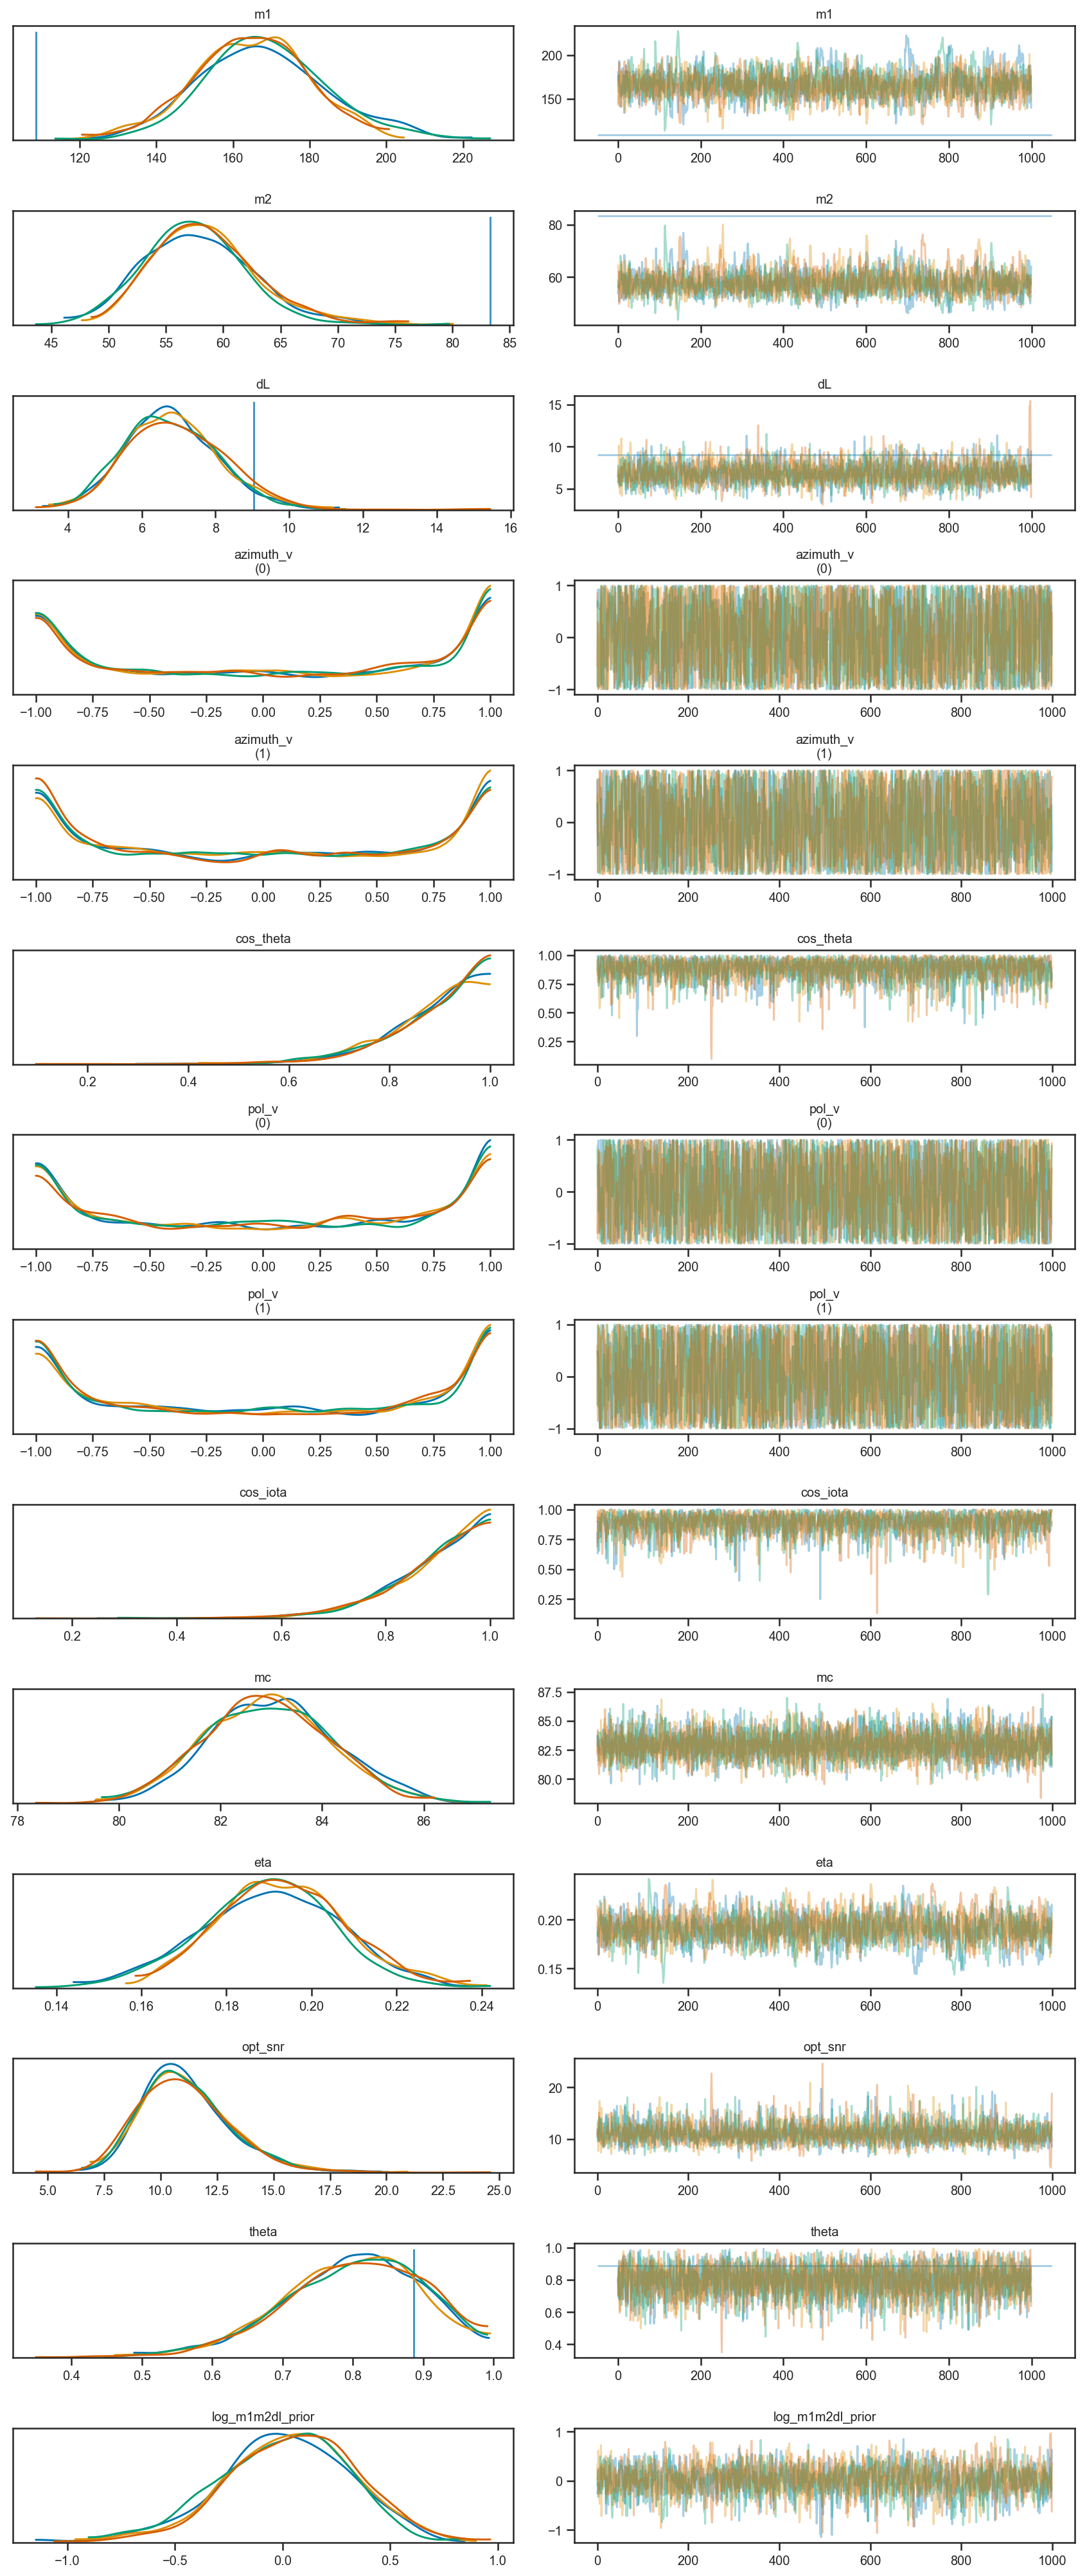

In [112]:
az.plot_trace(fit, lines=(('m1', {}, m1s[ifit]*(1+zs[ifit])),
                          ('m2', {}, m2s[ifit]*(1+zs[ifit])),
                          ('dL', {}, dls[ifit]),
                          ('theta', {}, thetas[ifit])))

In [101]:
c = fit.extract(permuted=True)

In [102]:
rhoobs[ifit], mean(c['theta']*c['opt_snr']), std(c['theta']*c['opt_snr'])

(8.647531037595419, 8.251708985982313, 1.0208741335867437)

In [103]:
osnr_interp = RectBivariateSpline(ms_osnr, ms_osnr, osnrs)

def optimal_snr(m1obs, m2obs, dl):
    return osnr_interp.ev(m1obs, m2obs)/dl

In [104]:
optimal_snr(m1s[ifit]*(1+zs[ifit]), m2s[ifit]*(1+zs[ifit]), dls[ifit])*thetas[ifit], rhoobs[ifit]

(3.710127731745111, 8.647531037595419)

In [108]:
3.71+np.max(randn(5000))

6.807030541665371

In [87]:
ifit

4460